## Dataset3_nasdaq

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('Dataset3_nasdaq_1985_2014.csv', names = ["nasdaq"])

In [3]:
df.head()

,nasdaq
0,3888.09
1,3857.94
2,3874.27
3,3874.94
4,3908.77


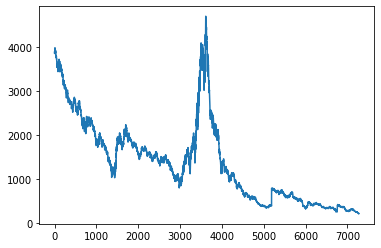

In [4]:
plt.plot(df['nasdaq'])

From data plot, we can say that it is a non-stationary data series.

**ADF Test**

In [5]:
def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = df[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('nasdaq')

Results of Dickey-Fuller Test for  nasdaq 

Test Statistic                   -2.381102
p-value                           0.147141
#Lags Used                       35.000000
Number of Observations Used    7240.000000
Critical Value (1%)              -3.431254
Critical Value (5%)              -2.861939
Critical Value (10%)             -2.566983
dtype: float64


ADF test: The test statistic is greater than the critical value, so we fail to reject the null hypothesis. So it is non-stationary series.
Also P value is greater than 0.05 so, from that also we can say it is non-stationary. 

**KPSS Test**

In [6]:
def kpss_test(atr):
    timeseries = df[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('nasdaq')

Results of KPSS Test for  nasdaq
Test Statistic           12.143812
p-value                   0.010000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


KPSS Test: The test statistic is greater than the critical value so we can reject the null hypothesis. So it is non-stationary series.


SO from both tests, we can say it is non-stationary series.

**Differencing with period 1 to make non-stationary data to stationary dataseries.**

In [7]:
df['Diff'] = df['nasdaq'].diff(periods=1)

In [8]:
df

,nasdaq,Diff
0,3888.09,NaN
1,3857.94,-30.15
2,3874.27,16.33
3,3874.94,0.67
4,3908.77,33.83
...,...,...
7271,216.40,2.08
7272,220.15,3.75
7273,221.74,1.59
7274,221.65,-0.09


In [9]:
adf_test('Diff')

Results of Dickey-Fuller Test for  Diff 

Test Statistic                -1.305224e+01
p-value                        2.130223e-24
#Lags Used                     3.600000e+01
Number of Observations Used    7.238000e+03
Critical Value (1%)           -3.431254e+00
Critical Value (5%)           -2.861939e+00
Critical Value (10%)          -2.566983e+00
dtype: float64


p value is less than the 0.05 so data is stationary.

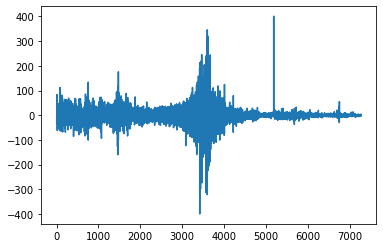

In [10]:
df['Diff'].plot()
plt.show()

In [11]:
data1 = df.iloc[:,0].values
dataset_array1 = [data1[0::1],data1[0::2],data1[0::4],data1[0::8],data1[0::12],data1[0::24]]

In [12]:
def plotting_function(MSE,MAE,name):
  interval = [1,2,3,4,5,6]

  barWidth = 0.25  
  r1 = np.arange(len(interval))
  r2 = [x + barWidth for x in r1]
  
  # Make the plot
  plt.bar(r1, MSE, color='b', width=barWidth, label='MSE')
  plt.bar(r2, MAE, color='g', width=barWidth, label='MAE')

  plt.xlabel('interval', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(interval))], ['1', '2', '4', '8', '12','24'])
  plt.title('MSE and MAE plot for '+(name))
  plt.legend()
  plt.show()
 

**single exponential smoothing**

In [13]:
def single_exp(data,interval,alpha):
  array1=data
  
  fv = np.array([None] * len(array1))
  for i in range(interval):
    fv[i]=array1[i]
   
  for i in range(interval, len(array1)):
    fv[i] = alpha * array1[i-interval] + (1 - alpha) * fv[i - interval]
  array = array1-fv
  arr = pd.DataFrame.from_dict({"nasdaq":array1,"Forecasted value":fv,"Error":array})
  return arr

In [14]:
interval = [1,2,4,8,12,24]
mse1=[]
mae1=[]
for i in interval:
  a = single_exp(df.iloc[:,0],i,0.9)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse1.append(round(mse_val,6))
  mae1.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse1)
print('MSE for each interval respectively \n',mae1)

MSE for each interval respectively 
 [1101.340197, 2057.483943, 3713.54713, 6914.831946, 9844.658568, 20992.987747]
MSE for each interval respectively 
 [17.540286, 24.758787, 34.261581, 47.628966, 57.559496, 85.368321]


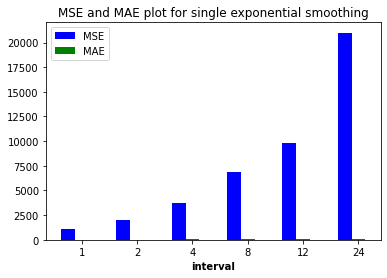

In [15]:
plotting_function(mse1,mae1,'single exponential smoothing')

**Double Exponential Smoothing**

In [16]:
def double_exp(data,interval,alpha,beta):
  array=data
  f = np.array([None] * len(array))
  a = np.array([None] * len(array))
  b = np.array([None] * len(array))
  

  f[0]=data[0]
  a[0] = array[0]
  b[0] = (array[(len(array)-1)] - array[0])/(len(array)-1)

  if interval<2:
    f[1] = a[0]+b[0]
    for i in range(2, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"nasdaq":array,"Forecasted value":f,"Error":array-f})
  else:
    for i in range(2,interval):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]

    for i in range(1,interval):
      f[i] = a[i-1] + b[i-1]

    for i in range(interval, len(array)):
      a[i-1] = alpha*array[i-1] + (1-alpha)*(a[i-2]+b[i-2])
      b[i-1] = beta*(a[i-1]-a[i-2]) + (1-beta)*b[i-2]
      f[i] = a[i-1] + b[i-1]
    arr = pd.DataFrame.from_dict({"nasdaq":array,"Forecasted value":f,"Error":array-f})
  return arr

In [17]:
interval = [1,2,4,8,12,24]
mse2=[]
mae2=[]
for i in interval:
  a = double_exp(df.iloc[:,0],i,0.9,0.01)
  mse_val = ((a.Error)**2).sum()/(len(a.Error)-i)
  mae_val = (abs(a.Error)).sum()/(len(a.Error)-i)
  mse2.append(round(mse_val,6))
  mae2.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse2)
print('MSE for each interval respectively \n',mae2)

MSE for each interval respectively 
 [1104.909446, 1105.061344, 1105.365267, 1105.973613, 1106.582629, 1108.413709]
MSE for each interval respectively 
 [17.538233, 17.540644, 17.545468, 17.555124, 17.564791, 17.593856]


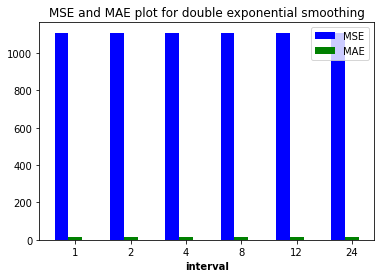

In [18]:
plotting_function(mse2,mae2,'double exponential smoothing')

**Triple Exponential Smoothing**

In [19]:
def initial_trend(data, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(data[i+season_len] - data[i]) / season_len
    return sum / season_len

def initial_seasonal(data, season_len):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(data)/season_len)
  # compute season averages
  for j in range(n_seasons):
    avg = ((data[(season_len*j):(season_len*j)+season_len]).sum())/float(season_len)
    season_averages.append(avg)
  # initial values
  for i in range(season_len):
    sum = 0.0
    for j in range(n_seasons):
      sum += data[season_len*j+i]-season_averages[j]
    seasonals[i] = sum/n_seasons
  return seasonals

def triple_exp(data, season_len, alpha, beta, gamma, n_preds):
  result = []
  error = []
  seasonals = initial_seasonal(data, season_len)
  for i in range(len(data)+n_preds):
    if i == 0: # initial values
      smooth = data[0]
      trend = initial_trend(data, season_len)
      result.append(data[0])
      continue
    if i >= len(data): # we are forecasting
      m = i - len(data) + 1
      result.append((smooth + m*trend) + seasonals[i%season_len])
    else:
      val = data[i]
      last_smooth, smooth = smooth, alpha*(val-seasonals[i%season_len]) + (1-alpha)*(smooth+trend)
      trend = beta * (smooth-last_smooth) + (1-beta)*trend
      seasonals[i%season_len] = gamma*(val-smooth) + (1-gamma)*seasonals[i%season_len]
      forecast = smooth+trend+seasonals[i%season_len]
      error = data - forecast
      result.append(forecast)
      
  SE = np.square(error)
  SSE = 0
  for i in SE:
    SSE+= i
  mse_val = SSE/(len(data)-1)
  mae_val = np.sum(abs(error)/len(error))
  return mse_val,mae_val

In [20]:
mse3 = []
mae3 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val = triple_exp(dataframe,1,0.9,0.02,0.95,1)
  mse3.append(round(mse_val,6))
  mae3.append(round(mae_val,6))

print('MSE for each interval respectively \n',mse3)
print('MSE for each interval respectively \n',mae3)

MSE for each interval respectively 
 [2223876.830126, 2233298.026276, 2238596.825256, 2241838.580041, 2258817.85846, 2263772.859663]
MSE for each interval respectively 
 [1151.951487, 1155.328765, 1157.497431, 1158.619594, 1161.902892, 1163.71419]


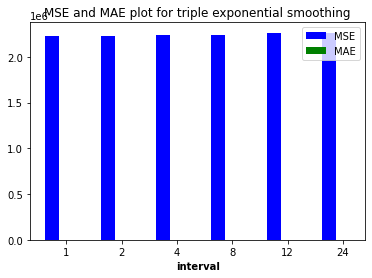

In [21]:
plotting_function(mse3,mae3,'triple exponential smoothing')

**ACF PACF Plot**

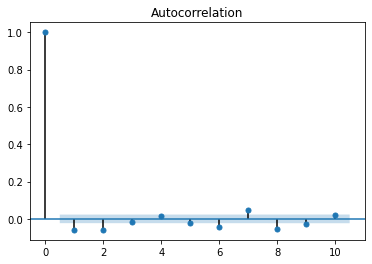

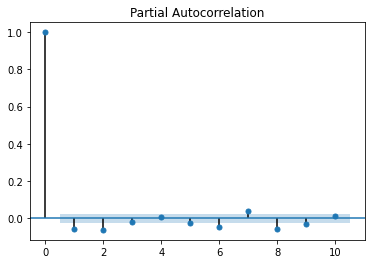

In [22]:
plot_acf(df.iloc[:,1].dropna(), lags=10)
plt.show()
plot_pacf(df.iloc[:,1].dropna(), lags=10)
plt.show()

pmdarima package install

In [4]:
!pip3 install pmdarima

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 2.1MB 15.9MB/s 
     |████████████████████████████████| 9.5MB 37.5MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [23]:
import pmdarima as pm
model = pm.auto_arima(df.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=5, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, 
                      trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71573.519, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71626.005, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71602.481, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71598.884, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71625.676, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=71573.861, Time=4.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=71573.643, Time=3.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=71574.051, Time=2.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71575.909, Time=0.72 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=71575.157, Time=4.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=71573.985, Time=0.83 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 19.593 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

**AR model**

In [24]:
from statsmodels.tsa.arima_model import ARIMA
def ar_model(data):
  model=ARIMA(data,order=(1,0,0)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [25]:
mse4 = []
mae4 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ar_model(dataframe)
  mse4.append(round(mse_val,6))
  mae4.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse4)
print('MSE for each interval respectively \n',mae4)

MSE for each interval respectively 
 [2345.005951, 4563.709955, 8485.987729, 11755.640896, 19184.194585, 39116.178197]
MSE for each interval respectively 
 [17.872703, 25.39514, 35.067027, 49.806639, 61.587377, 96.491148]


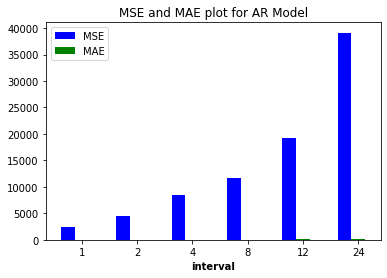

In [26]:
plotting_function(mse4,mae4,'AR Model')

**MA Model**

In [27]:
def ma_model(data):
  model=ARIMA(data,order=(0,0,1)).fit()
  prediction = model.fittedvalues
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [28]:
mse5 = []
mae5 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = ma_model(dataframe)
  mse5.append(round(mse_val,6))
  mae5.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse5)
print('MSE for each interval respectively \n',mae5)

MSE for each interval respectively 
 [235534.933452, 244132.714161, 246639.938514, 248921.766789, 275789.188768, 280409.268583]
MSE for each interval respectively 
 [392.66799, 396.733616, 399.199812, 399.997749, 412.406107, 414.608433]


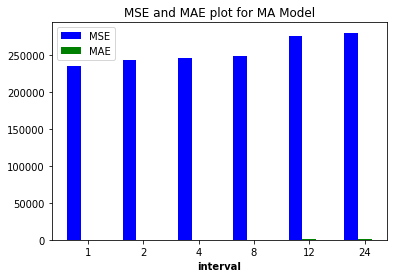

In [29]:
plotting_function(mse5,mae5,'MA Model')

**ARIMA Model**

In [30]:
def arima_model(data):
  model=ARIMA(data,order=(1,1,1)).fit()
  prediction = model.fittedvalues
  data = np.delete(data,[0])
  error = data - prediction
  mse_val = np.sum((error)**2)/len(error)
  mae_val = np.sum(abs(error))/len(error)
  return mse_val,mae_val,prediction

In [31]:
mse6 = []
mae6 = []
final_forecasted_list = []
for dataframe in dataset_array1:
  mse_val,mae_val,prediction = arima_model(dataframe)
  mse6.append(round(mse_val,6))
  mae6.append(round(mae_val,6))
  final_forecasted_list.append(prediction)

print('MSE for each interval respectively \n',mse6)
print('MSE for each interval respectively \n',mae6)

MSE for each interval respectively 
 [2788888.821033, 2790846.143661, 2790384.01042, 2789698.004334, 2803715.77028, 2790607.664282]
MSE for each interval respectively 
 [1375.857424, 1376.361219, 1376.869147, 1377.949929, 1381.091798, 1381.500301]


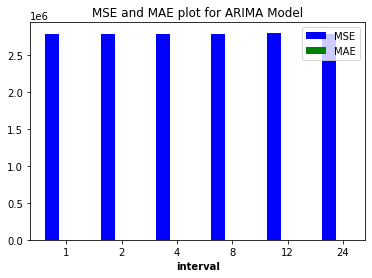

In [32]:
plotting_function(mse6,mae6,'ARIMA Model')